In [1]:
import numpy as np


In [2]:
"""
单层决策树分类函数
"""
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray  = np.ones((np.shape(dataMatrix)[0],1))#分类结果初始化为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen]<= threshVal] = -1.0 
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

In [3]:
"""
找到数据集上最佳的单层决策树
"""
def buildStump(dataArr, classLabels, D): #最佳是基于数据的权重向量D来定义的
    dataMatrix = np.mat(dataArr)
    labelMat= np.mat(classLabels).T
    m, n = np.shape(dataMatrix)  #训练数据大小
    numSteps = 10.0 #特征的所有可能值在上遍历
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m, 1)))
    minError = np.inf  #将最小错误率设置为无穷大
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()  #特征中最大值
        stepSize = (rangeMax-rangeMin)/numSteps #步长
        for j in range(-1, int(numSteps)+1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin+ float(j)*stepSize) #计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)# 计算分类结果
                errArr = np.mat(np.ones((m,1))) # 初始化误差矩阵 
                errArr[predictedVals == labelMat] = 0 #预测正确，误差矩阵赋值为0
                #计算加权错误率
                weightedError = D.T*errArr #计算加权误差率
#                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError: #找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i   #最佳单层决策树信息保存到字典
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst


而alpha的计算公式如下： $$α= \frac{1}{2}ln(\frac{1-ε}{ε})$$
计算出alpha值之后，可以对权重向量$D$进行更新，以使那些正确分类的样本的权重降低而错分样本的权重升高。$D$的计算方法如下： 如果某个样本被正确分类，那么该样本的权重更改为： $$D_i^{(t+1)}=\frac{D_i^{(t)}e^{-α}}{Sum(D)}$$ 而如果某个样本被错分，那么该样本的权重更改为;
$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{α}}{Sum(D)}$$ 在计算出$D$之后，AdaBoost又开始下一轮迭代。AdaBoost算法会不断重复训练和调整权重的过程，直到错误率为0或者弱分类器的数目达到用户的指定值为止。

In [4]:
# 基于单层决策树AdaBoost训练过程
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m) #初始化权重
    aggClassEst = np.mat(np.zeros((m,1))) #记录每个数据点的类别估计累计值
    for i in range(numIt):
        bestStump,error, classEst = buildStump(dataArr, classLabels, D)
#         print("D:",D.T)
        alpha = float(0.5*np.log((1.0-error)/max(error, 1e-16)))  #计算弱学习算法权重
        bestStump['alpha'] = alpha  #存储弱学习算法权重
        weakClassArr.append(bestStump) #存储单层决策树
#         print("classEst:", classEst.T)
        #迭代D
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)  #根据公式计算e的指数项
        D = np.multiply(D, np.exp(expon))
        D = D/D.sum() #根据样本权重，更新权重
        aggClassEst += alpha*classEst #将各数据点类别估计值累加
#         print("aggClassEst:",aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1))) #计算误差
        ErrorRate = aggErrors.sum()/m
        print ("total error:",ErrorRate,"\n")
        if ErrorRate ==0.0:  break
    return weakClassArr, aggClassEst


In [9]:
"""
AdaBoost分类函数
"""

def adaClassify(datToClass, classifierArr):
    dataMatrix =np.mat(datToClass)
    m = np.shape(dataMatrix)[0] #待分类矩阵样本数
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst #样本加上权重
        print(aggClassEst)
    return np.sign(aggClassEst)  # 计算各元素的符号值 1（+），0，-1（-） 

示例：在一个难数据集上应用AdaBoost


（1） 收集数据：提供的文本文件。
（2） 准备数据：确保类别标签是+1和-1而非1和0。
（3） 分析数据：手工检查数据。
（4） 训练算法：在数据上，利用adaBoostTrainDS()函数训练出一系列的分类器。
（5） 测试算法：我们拥有两个数据集。在不采用随机抽样的方法下，我们就会对AdaBoost和Logistic回归的结果进行完全对等的比较。
（6） 使用算法：观察该例子上的错误率。不过，也可以构建一个Web网站，让驯马师输入马的症状然后预测马是否会死去。

In [6]:
def loadDataSet(fileName):
    """
    函数能够自检出特征的数目
    """
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [10]:
dataMat,labelMat = loadDataSet('horseColicTraining2.txt')
classifierArray,aggClassEst = adaBoostTrainDS(dataMat,labelMat,50)

total error: 0.2842809364548495 

total error: 0.2842809364548495 

total error: 0.24749163879598662 

total error: 0.24749163879598662 

total error: 0.25418060200668896 

total error: 0.2408026755852843 

total error: 0.2408026755852843 

total error: 0.22073578595317725 

total error: 0.24749163879598662 

total error: 0.23076923076923078 

total error: 0.2408026755852843 

total error: 0.2140468227424749 

total error: 0.22742474916387959 

total error: 0.21739130434782608 

total error: 0.22073578595317725 

total error: 0.21739130434782608 

total error: 0.22408026755852842 

total error: 0.22408026755852842 

total error: 0.23076923076923078 

total error: 0.22408026755852842 

total error: 0.2140468227424749 

total error: 0.20735785953177258 

total error: 0.22408026755852842 

total error: 0.22408026755852842 

total error: 0.2140468227424749 

total error: 0.22073578595317725 

total error: 0.2040133779264214 

total error: 0.20735785953177258 

total error: 0.21070234113712

In [11]:
testeMat,testLabelMat = loadDataSet('horseColicTraining2.txt')
prediction10 = adaClassify(testeMat,classifierArray)
#求得预测错误率
m,n = np.shape(testeMat)
errArr = np.mat(np.ones((m,1)))
errArr = np.multiply((prediction10!=np.mat(testLabelMat).T),errArr)
errRate = errArr.sum()/m
errRate

[[-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

 [ 5.73378563e-01]]
[[-0.28979796]
 [ 0.59622973]
 [ 1.4161456 ]
 [-0.25525511]
 [-0.2399426 ]
 [ 1.46317908]
 [ 1.29448145]
 [ 0.76110635]
 [-0.54467576]
 [ 0.7944783 ]
 [-0.09119061]
 [ 1.18606137]
 [ 1.71136609]
 [ 0.3689492 ]
 [ 0.96210273]
 [-0.45358457]
 [-1.50996885]
 [ 0.4065752 ]
 [ 0.1393183 ]
 [-0.22051354]
 [ 0.33692267]
 [ 2.12155381]
 [ 1.53120804]
 [ 1.4606594 ]
 [ 0.45391754]
 [ 0.21912948]
 [ 0.31206845]
 [ 0.93041726]
 [ 0.16903029]
 [ 2.39944596]
 [-0.85864851]
 [ 0.03635592]
 [ 1.07281456]
 [ 0.72018651]
 [-0.15737909]
 [-1.93332122]
 [-0.42047299]
 [ 0.08307441]
 [ 1.73553766]
 [ 0.19968129]
 [-2.04099063]
 [ 0.45962545]
 [ 0.66364894]
 [-0.9414206 ]
 [-1.45099726]
 [-1.07388067]
 [-0.99788904]
 [ 1.89414908]
 [-0.81561892]
 [-1.65391475]
 [ 1.43080411]
 [ 0.53289378]
 [ 1.43061134]
 [ 0.7339176 ]
 [-0.27331075]
 [ 0.03664914]
 [ 0.33917944]
 [-0.1635674 ]
 [-0.56489266]
 [-1.32028274]
 [ 1.35942454]
 [ 1.67248219]
 [-0.3733584 ]
 [ 0.14594113]
 [-0.45215364]
 [ 0.

0.18729096989966554

In [21]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0]-delX], [cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print('the Area Under the Curve is: ', ySum*xStep)
        
        

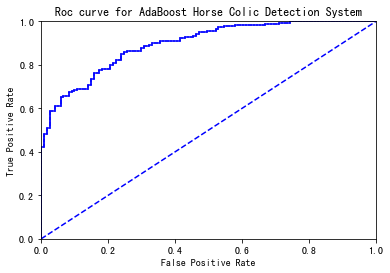

the Area Under the Curve is:  0.8953941870182941


In [22]:
plotROC(aggClassEst.T, labelMat)